# Purpose

When we found the genre similarity between 2 games (in Part 2), we noted that a few games with a high genre similarity to NieR can have very different asthetics and gameplay, which would indicate that we should also pay some attention to these components. Since there isn't a direct dataset for this, we can consider a proxy: how games are described. 

Given that the description is likely an important factor in a person decising on which game to buy, we should consider which games have a similar description to that of NieR.

We are making 2 assumptions here: we are __assuming that customers make decision of whether to buy games based on the game's description__, which may or may not be part of their decision making process, and we are __assuming that the description of the game is an accurate representation of the game__!

In [41]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np  # For data processing
import pandas as pd  # For data IO
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage

try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except ImportError:
    pass

import re  # For text processing
import nltk  # For NLP
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer(language='english')

from matplotlib import pyplot as plt  # For plotting
import seaborn as sns  # For plotting
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [39]:
KM_RANDOM_SEED = 42

In [3]:
# We'll re-load the games dataset
apps = pd.read_csv(
    '../data/raw/appdetail.csv'
)

# And remove the rows with DLCs
mask = apps.dropna(
    subset=['categories_description']  # drop the column with NaN
)['categories_description'].str.contains('Downloadable Content')

apps_noDLC = apps.dropna(
    subset=['categories_description']
)[~mask]

display(apps_noDLC.head())
print(apps_noDLC.shape)

,appid,name,release_date__date,genre_description,categories_description,short_description,about_the_game
0,391220,Rise of the Tomb Raider,"Feb 9, 2016","Action,Adventure","Full controller support,Single-player,Steam Ac...",Rise of the Tomb Raider: 20 Year Celebration i...,"<img src=""https://steamcdn-a.akamaihd.net/stea..."
1,524220,NieR:Automata™,"Mar 17, 2017","Action,RPG,Violent","Partial Controller Support,Single-player,Steam...","NieR: Automata tells the story of androids 2B,...","<img src=""https://steamcdn-a.akamaihd.net/stea..."
2,441830,I am Setsuna,"Jul 19, 2016",RPG,"Full controller support,Single-player,Steam Ac...",Inspired by the timeless classic Chrono Trigge...,"<img src=""https://steamcdn-a.akamaihd.net/stea..."
3,410850,Dragon Quest Heroes,"Dec 3, 2015","Action,RPG","Full controller support,Single-player,Steam Ac...","DRAGON QUEST, one of the most iconic RPG serie...","<img src=""https://%CDN_HOST_MEDIA_SSL%/steam/a..."
4,324510,Boundless,"Nov 13, 2014","Action,Adventure,Early Access,Indie,Massively ...","Co-op,Cross-Platform Multiplayer,Full controll...","Boundless is an epic, single universe voxel sa...","<img src=""https://steamcdn-a.akamaihd.net/stea..."


(84, 7)


The column that encodes the information we need is `about_the_game`. Before we start on the process of finding the similarity between NieR and the different games, we have to clean it (note the HTML tags). Let's begin by examining it more closely.

In [5]:
display(apps_noDLC['about_the_game'].head())
display(apps_noDLC['about_the_game'].tail())

0    <img src="https://steamcdn-a.akamaihd.net/stea...
1    <img src="https://steamcdn-a.akamaihd.net/stea...
2    <img src="https://steamcdn-a.akamaihd.net/stea...
3    <img src="https://%CDN_HOST_MEDIA_SSL%/steam/a...
4    <img src="https://steamcdn-a.akamaihd.net/stea...
Name: about_the_game, dtype: object

91     *This is a single player only title*<br><br>Ve...
92     <p>Experience the dramatic intensity of the fr...
93     Make rectangles of the same type of yosumin to...
95     \r\n\t\t\t\t\t<p>Your husband Richard lies dea...
101    Clementine Valley used to be the place to be! ...
Name: about_the_game, dtype: object

The first 5 and last 5 rows tell a similar story; text is encapsulated in HTML elements. We should then make an effort to remove HTML tags before proceeding with text processing. The small function below handles this.

In [6]:
def remove_tags(text: str) -> str:
    """Small function to remove HTML tags from text."""
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

Let's test the function!

In [7]:
apps_noDLC.iloc[1]['about_the_game']

'<img src="https://steamcdn-a.akamaihd.net/steam/apps/524220/extras/Nier_PRE_Launch-ENG_UK_Multi_06_Mod.jpg?t=1515664275" ><br>NieR: Automata tells the story of androids 2B, 9S and A2 and their battle to reclaim the machine-driven dystopia overrun by powerful machines.<br><br>Humanity has been driven from the Earth by mechanical beings from another world. In a final effort to take back the planet, the human resistance sends a force of android soldiers to destroy the invaders. Now, a war between machines and androids rages on... A war that could soon unveil a long-forgotten truth of the world.<br><br>Key Features:<br><ul class="bb_ul"><li><strong>Action-Packed Battles</strong> – Players will switch between using melee and ranged attacks in battle against hordes of enemies and challenging bosses across a variety of open field maps. The tight controls and incredibly fluid combat are simple to learn for newcomers while offering plenty of depth for more experienced action gamers. Players ca

In [8]:
remove_tags(apps_noDLC.iloc[1]['about_the_game'])

'NieR: Automata tells the story of androids 2B, 9S and A2 and their battle to reclaim the machine-driven dystopia overrun by powerful machines.Humanity has been driven from the Earth by mechanical beings from another world. In a final effort to take back the planet, the human resistance sends a force of android soldiers to destroy the invaders. Now, a war between machines and androids rages on... A war that could soon unveil a long-forgotten truth of the world.Key Features:Action-Packed Battles – Players will switch between using melee and ranged attacks in battle against hordes of enemies and challenging bosses across a variety of open field maps. The tight controls and incredibly fluid combat are simple to learn for newcomers while offering plenty of depth for more experienced action gamers. Players can perform high-speed battle actions—combining light and heavy attacks—and switch through an arsenal of weaponry while evading enemies with speed and style. Beautifully Desolate Open-Wor

Looks good enough!

In [9]:
apps_noDLC['about_the_game_clean'] = apps_noDLC['about_the_game'].apply(remove_tags)

With this step done, we can now start finding the similarity between games. 

### Description similarity

We will approach this by considering how closely related two bodies of text are. The area that focuses on this is NLP (Natural Language Processing). While we will not elve into the theory behind each step, a small explanation is give. We will start with tokenizing and stemming.

Tokenization is the process by which we break down descriptions into individual sentences or words, as needed. Besides the tokenization method provided by NLTK (which has already been imported), we may have to perform additional filtration to remove tokens which are entirely numeric values or punctuation.

Stemming is the process by which we convert a word from its different forms to the root word. This helps us establish meaning to different forms of the same words without having to deal with each form separately. For example, the words 'mechanic', 'mechanical', and 'mechanically' all get stemmed to 'mechan'.

We will create a function that tokenizes and stems the game descriptions all in one go.

In [12]:
# Define a function to perform both tokenization and stemming
def tokenize_and_stem(text):
    
    # Tokenize by sentence, then by word
    tokens = []
    
    # First we tokenize by sentence, i.e. we split the game
    # description into sentences
    for sent in nltk.sent_tokenize(text):
        # Then we tokenize by word, i.e. we split each sentence
        # into it's constituent words
        for word in nltk.word_tokenize(sent):
            tokens.append(word)
    
    # Filter out raw tokens to remove noise
    # This also remove puntuation.
    filtered_tokens = [
        token for token in tokens 
        if re.search('[a-zA-Z]', token)
    ]

    # Stem the filtered_tokens
    stems = [stemmer.stem(word) for word in filtered_tokens]
    
    return stems

The purpose of the function is to be used as an input function for another process: TF-IDF, or Term Frequency - Inverse Document Frequency. This process assigns a weight to each word based on both it's frequency in a game description, as well as based on how often it appears in all game descriptions. This way, a low occurence word has higher weighting compared to a word that occurs very often (so the term "machine" will have a bigger weight compared to other, more frequenty occuring words). 

In simpler terms, TF-IDF recognizes words which are unique and important to any given description.

It is important to note that we should vary the stemmer. For the purposes of this notebook, we are using the Snoball Stemmer, which is one of 3 major stemmers most commonly used, but we should also try the Lancaster and the Porter stemmers to see if they make a difference in the similarity predicted.

---

The `TfidfVectorizer` is sci-kit learn's implementation of the TF-IDF process. It does have a number of hyperparameters that need tuning to find the best weights for each word. These include:

 - max_features: the number of terms, ordered by term frequency, with which to build a vocabulary. We will vary these between None and 100,000 to 200,000 (in 100,000 steps).
 - max_df, min_df: a threshold that specifies the frequency of terms to ignore when building the vocabulary. max_df removes words that occur in too many documents, while min_df removes words that occur in too few. We will vary max_df between 0.7 and 1, and min_df between 0.3 and 0.
 - ngram_range: the range of n-grams to sample when building the vocabulary. We will vary this parameter between (1,1) and (1,3).

We are going to evaluate the process by clustering the data and checking the clusters. Clustering suffers from being an unsupervised method, which means that it is very difficult to score. We can use a metric like the Davies-Bouldin index to score how well defined the clusters we generate are. This doesn't really tell us if the games are being well clustered in terms of the game description, but we can use it as a starting point.

To facilitate hyperparameter search, we will create a pseudo pipeline to which we can pass on hyperparameters and evaluate clusters.

In [17]:
def preprocess_and_cluster(max_features, max_df, min_df, ngram_range, n_clusters):
    """Pseudo pipeline for preprocessing and clustering data."""
    # Instantiate TfidfVectorizer object with stopwords and tokenizer
    # parameters for efficient processing of text
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        max_df=max_df,
        min_df=min_df,
        stop_words='english',
        use_idf=True, 
        tokenizer=tokenize_and_stem,
        ngram_range=ngram_range
    )
    
    # Fit and transform the data to get the tfidf matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(
        [x for x in apps_noDLC['about_the_game_clean']]
    )
    
    # We then use the matrix to cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)
    
    # Calculate the Davies-Bouldin Index
    db_index = davies_bouldin_score(
        tfidf_matrix.toarray(),  # Convert from sparse to dense
        kmeans.labels_
    )
    
    silhouette = silhouette_score(
        tfidf_matrix.toarray(),  # Convert from sparse to dense
        kmeans.labels_
    )
    
    return {
        'max_features': max_features, 
        'max_df': max_df, 
        'min_df': min_df, 
        'ngram_range': ngram_range, 
        'n_clusters': n_clusters,
        'db_index': db_index,
        'silhouette_score': silhouette
    }

Now that we have the pipeline, all we need to do is pass in the data. We will use `itertools.product` to create an iterator to help reduce code!

In [20]:
max_features_list = [None] + list(range(50000, 250000, 50000))
max_df_list = np.arange(0.7, 1, 0.1)
min_df_list = np.arange(0, 0.3, 0.1)
ngram_range_list = [(1,n) for n in range(2,5)]
n_clusters_list = list(range(4,8))

combos = itertools.product(
    max_features_list, 
    max_df_list, 
    min_df_list, 
    ngram_range_list, 
    n_clusters_list
)

results = [
    cluster(
        max_features=combo[0],
        max_df=combo[1], 
        min_df=combo[2],
        ngram_range=combo[3],
        n_clusters=combo[4]
    )
    for combo in combos
]

The Davies-Bouldin index is lower if the clusters are more defined, and for the Silhouette Coefficient, the closer it is 1, the better.

In [21]:
# We can look at the performance based on the input parameters using pandas
results_df = pd.DataFrame(results)
display(results_df.sort_values(
    ['silhouette_score', 'db_index'], 
    ascending=[False, True]
).head(15))

,max_features,max_df,min_df,ngram_range,n_clusters,db_index,silhouette_score
13,NaN,0.7,0.1,"(1, 2)",5,3.336416,0.071897
17,NaN,0.7,0.1,"(1, 3)",5,3.336416,0.071897
21,NaN,0.7,0.1,"(1, 4)",5,3.336416,0.071897
49,NaN,0.8,0.1,"(1, 2)",5,3.336416,0.071897
53,NaN,0.8,0.1,"(1, 3)",5,3.336416,0.071897
57,NaN,0.8,0.1,"(1, 4)",5,3.336416,0.071897
85,NaN,0.9,0.1,"(1, 2)",5,3.336416,0.071897
89,NaN,0.9,0.1,"(1, 3)",5,3.336416,0.071897
93,NaN,0.9,0.1,"(1, 4)",5,3.336416,0.071897
121,NaN,1.0,0.1,"(1, 2)",5,3.336416,0.071897


We can use either or both scores to find out the best combination of hyperparameters, but we will focus on the Silhouette score for this exercise.

In [38]:
results_df[results_df['silhouette_score'] == results_df['silhouette_score'].max()]

,max_features,max_df,min_df,ngram_range,n_clusters,db_index,silhouette_score
13,NaN,0.7,0.1,"(1, 2)",5,3.336416,0.071897
17,NaN,0.7,0.1,"(1, 3)",5,3.336416,0.071897
21,NaN,0.7,0.1,"(1, 4)",5,3.336416,0.071897
49,NaN,0.8,0.1,"(1, 2)",5,3.336416,0.071897
53,NaN,0.8,0.1,"(1, 3)",5,3.336416,0.071897
57,NaN,0.8,0.1,"(1, 4)",5,3.336416,0.071897
85,NaN,0.9,0.1,"(1, 2)",5,3.336416,0.071897
89,NaN,0.9,0.1,"(1, 3)",5,3.336416,0.071897
93,NaN,0.9,0.1,"(1, 4)",5,3.336416,0.071897
121,NaN,1.0,0.1,"(1, 2)",5,3.336416,0.071897


In [40]:
# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
tfidf_vectorizer = TfidfVectorizer(
    max_features=200000,
    max_df=0.8,
    min_df=0.1,
    stop_words='english',
    use_idf=True, 
    tokenizer=tokenize_and_stem,
    ngram_range=(1,3)
)

tfidf_matrix = tfidf_vectorizer.fit_transform(
    [x for x in apps_noDLC['about_the_game_clean']]
)
kmeans = KMeans(n_clusters=5, random_state=KM_RANDOM_SEED)
kmeans.fit(tfidf_matrix)

KMeans(n_clusters=5, random_state=42)

We can then use the cosine similarity to calculate a similarity between 2 games.

In [42]:
# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

And plot a dendrogram with the results

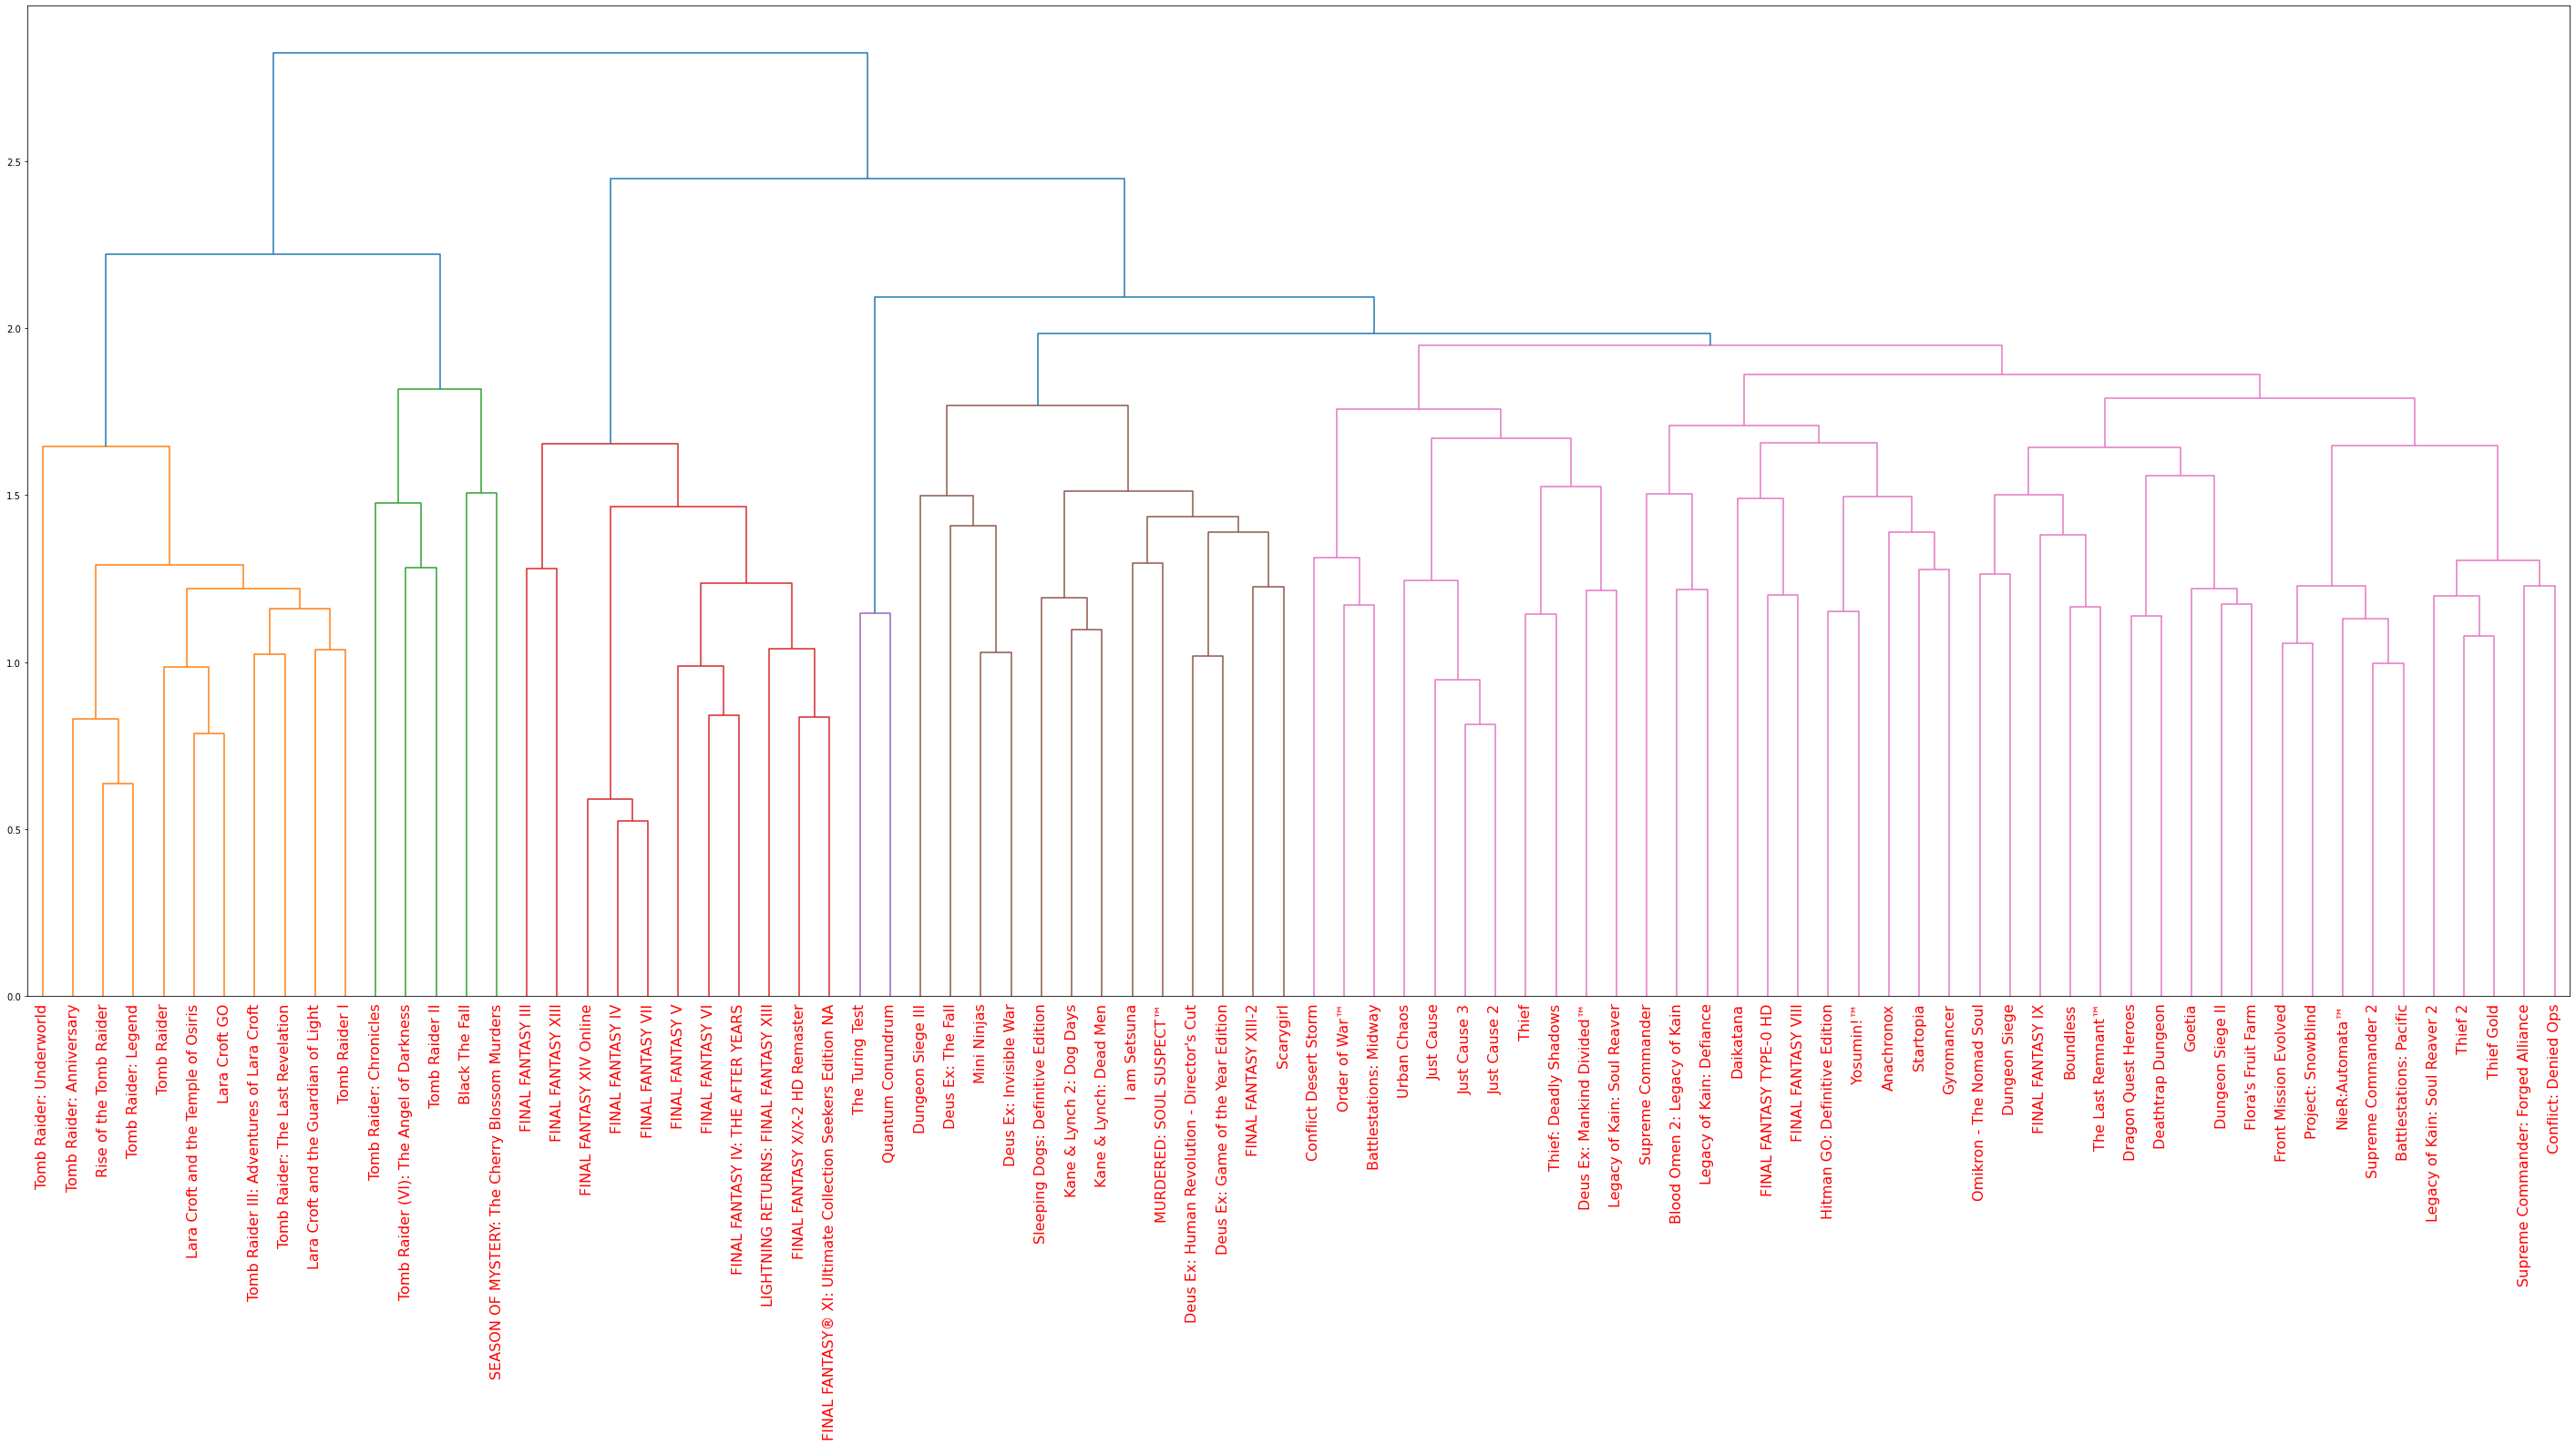

In [43]:
# Create mergings matrix 
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings,
               labels=[x for x in apps_noDLC["name"]],
               leaf_rotation=90,
               leaf_font_size=16,
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(50, 20)

# Show the plotted dendrogram
plt.show()

The procedure seems to have worked reasonably well, cosidering there is a cluster of Tomb Raiser games, and a cluster of Final Fantasy games.

In [45]:
similarity_to_nier = pd.DataFrame(
    cosine_similarity(tfidf_matrix),
    index = apps_noDLC['name'],
    columns = apps_noDLC['name']
)['NieR:Automata™']
display(similarity_to_nier.sort_values().tail(10))

name
LIGHTNING RETURNS: FINAL FANTASY XIII    0.342523
FINAL FANTASY XIII-2                     0.354894
The Last Remnant™                        0.357762
Scarygirl                                0.368463
Battlestations: Pacific                  0.392891
Battlestations: Midway                   0.393086
Supreme Commander 2                      0.398866
FINAL FANTASY TYPE-0 HD                  0.401056
Front Mission Evolved                    0.417354
NieR:Automata™                           1.000000
Name: NieR:Automata™, dtype: float64

As we can see, the top games from our analysis have similar descriptive components to NieR: Front Mission Evolved has machines and technology NieR is also famed for; Final Fantasy Type 0 has similar gameplay elements; The Last Remnant has similar gameplay aesthetics. Final Fantasy XIII-2 and XIII-3 also have similar aesthetics.

<AxesSubplot:ylabel='Frequency'>

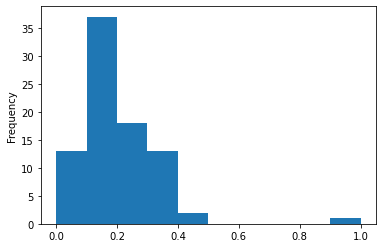

In [46]:
similarity_to_nier.plot(kind='hist')

Importantly for our purpose, the data is very close to a normally distributed one (ignoring NieR itself), meaning that it could be used in KMeans clustering.

In [47]:
apps_noDLC['descr_sim_NieR'] = similarity_to_nier.values

Let's save this data and use it in a final clustering exercise in the next Notebook!

In [49]:
apps_noDLC[['appid', 'descr_sim_NieR']].to_json(
    '../data/processed/apps_with_descrsim.json'
)